In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder

from sklearn.neighbors import KNeighborsClassifier

import sys
import os

sys.path.append(os.path.abspath("../.."))

from utils.evaluation import Evaluation

from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE
from collections import Counter


pd.set_option("display.max_columns", None)

In [2]:
path = "../../data/diabetes_processed_dataset.csv"

df = pd.read_csv(path)

In [3]:
X = df.drop(['diabetes'], axis = 1)
y = df['diabetes']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
encoder = TargetEncoder(cols=['location'])
X_train['location'] = encoder.fit_transform(X_train['location'], y_train)
X_test['location'] = encoder.transform(X_test['location'])

In [6]:
knn = KNeighborsClassifier()

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

Accuracy: 0.9542


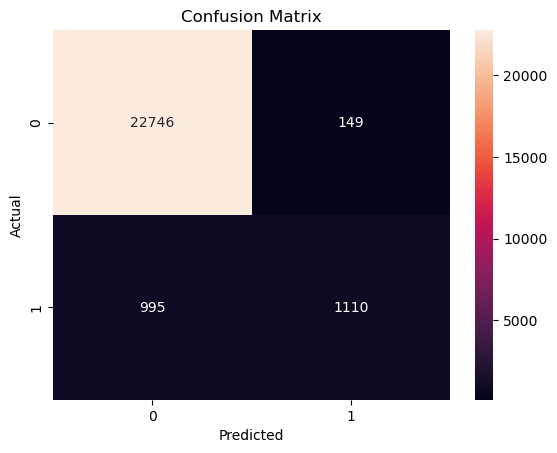

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     22895
           1       0.88      0.53      0.66      2105

    accuracy                           0.95     25000
   macro avg       0.92      0.76      0.82     25000
weighted avg       0.95      0.95      0.95     25000



In [7]:
eval = Evaluation()

eval.evaluate_model(y_test, y_pred)

## SMOTE

In [8]:
counter = Counter(y_train)
print('Before', counter)

Before Counter({0: 68605, 1: 6395})


In [9]:
smt = SMOTE()
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

In [10]:
counter = Counter(y_train_sm)
print('After', counter)

After Counter({0: 68605, 1: 68605})


In [11]:
knn = KNeighborsClassifier()

knn.fit(X_train_sm, y_train_sm)
y_pred = knn.predict(X_test)

Accuracy: 0.8790


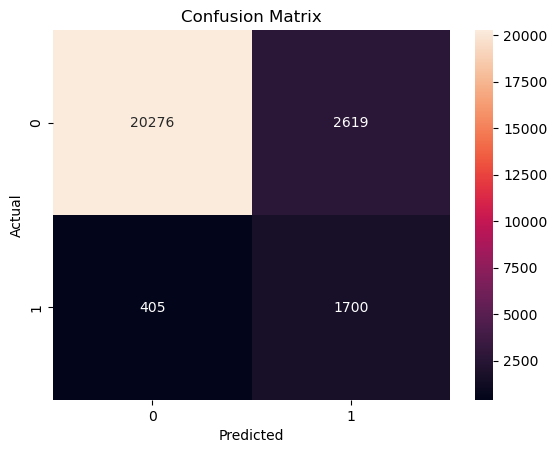

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93     22895
           1       0.39      0.81      0.53      2105

    accuracy                           0.88     25000
   macro avg       0.69      0.85      0.73     25000
weighted avg       0.93      0.88      0.90     25000



In [12]:
eval = Evaluation()

eval.evaluate_model(y_test, y_pred)

## Grid SMOTE

In [13]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [20, 30, 40, 50],
    'p': [1, 2]
}

smaller_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree']
}

In [14]:
knn = KNeighborsClassifier()

In [15]:
grid_search = GridSearchCV(knn, param_grid, n_jobs=1, cv=5, scoring='accuracy', verbose=2)
grid_search.fit(X_train_sm, y_train_sm)

print(f"Melhores parâmetros:\n {grid_search.best_params_}")

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
[CV] END algorithm=auto, leaf_size=20, n_neighbors=3, p=1, weights=uniform; total time=  13.3s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=3, p=1, weights=uniform; total time=  19.5s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=3, p=1, weights=uniform; total time=  20.7s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=3, p=1, weights=uniform; total time=  18.4s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=3, p=1, weights=uniform; total time=  19.4s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=3, p=1, weights=distance; total time=  17.2s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=3, p=1, weights=distance; total time=  18.6s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=3, p=1, weights=distance; total time=  17.5s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=3, p=1, weights=distance; total time=  19.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=3, p=1, weights=distance; 

/home/matt/anaconda3/envs/diabetes-prediction/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Melhores parâmetros:
 {'algorithm': 'kd_tree', 'leaf_size': 20, 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}


In [16]:
knn = KNeighborsClassifier(
    n_neighbors=3,
    weights='distance',
    algorithm='kd_tree',
    leaf_size=20,
    p=1
)

knn.fit(X_train_sm, y_train_sm)
y_pred = knn.predict(X_test)

Accuracy: 0.9137


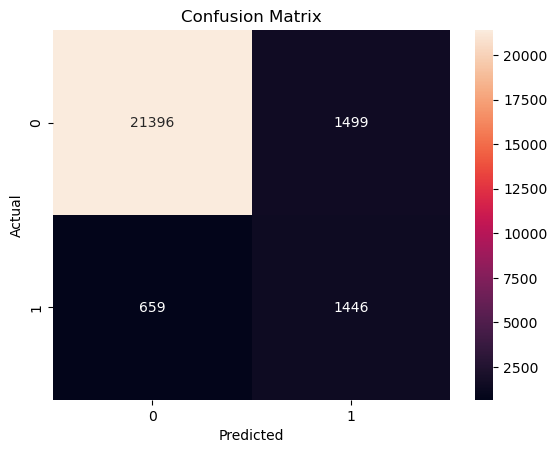

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     22895
           1       0.49      0.69      0.57      2105

    accuracy                           0.91     25000
   macro avg       0.73      0.81      0.76     25000
weighted avg       0.93      0.91      0.92     25000



In [17]:
eval = Evaluation()

eval.evaluate_model(y_test, y_pred)